In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution
from sklearn.base import BaseEstimator, ClassifierMixin


import sys
sys.path.append('../scripts')

import models
from models import *
import data
import utils

%load_ext autoreload
%autoreload 2

In [6]:
param_space = {
    "min_child_weight" : FloatDistribution(0.01, 10, log = True),
    "n_estimators" : IntDistribution(20, 50),
    #"eta" : FloatDistribution(0.01, 0.5),
    #"max_leaves" : IntDistribution(2, 128),
    "max_depth" : IntDistribution(2, 10),
    "l2_weight" : FloatDistribution(0, 100),
    "fair_weight" : FloatDistribution(0, 0) 
}
param_space_fair = param_space.copy()
param_space_fair["fair_weight"] = FloatDistribution(0.01, 2, log = True)


In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

def tune_hyperparam(X, Y, param_space, model):
    search = OptunaSearchCV(
        model,
        param_space,
        n_trials=50,
        cv=ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42),
        n_jobs=-1,
        random_state=42,
        verbose=0,
    )
    search.fit(X, Y)
    model = models.XtremeFair(**search.best_params_)
    model.fit(X, Y)
    return model

def eval_model(model, X, Y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    eop = utils.equal_opportunity_score(Y, y_pred, X.iloc[:, 0].values)
    spd = utils.statistical_parity_score(Y, y_pred, X.iloc[:, 0].values)
    el = utils.equalized_loss_score(Y, y_prob, X.iloc[:, 0].values)
    roc = roc_auc_score(Y, y_pred)
    return eop, spd, el, roc

for dataset in ["german", "taiwan"]:
    X, Y = data.load_dataset(dataset)
    for train_index, test_index in kf.split(X):
        X_train, Y_train = X.iloc[train_index], Y.iloc[train_index]
        X_test, Y_test = X.iloc[test_index], Y.iloc[test_index]
        
        model = tune_hyperparam(X_train, Y_train, param_space, models.XtremeFair())
        eop, spd, el, roc = eval_model(model, X_train, Y_train)
        results.append(
            ["no_fair",
            dataset,
            "train",
            eop,
            spd,
            el,
            roc,
            ]
        )
        eop, spd, el, roc = eval_model(model, X_test, Y_test)
        results.append(
            ["no_fair",
            dataset,
            "test",
            eop,
            spd,
            el,
            roc,
            ]
        )

        model = tune_hyperparam(X_train, Y_train, param_space_fair, models.XtremeFair())
        eop, spd, el, roc = eval_model(model, X_train, Y_train)
        results.append([
            "fair",
            dataset,
            "train",
            eop,
            spd,
            el,
            roc
        ])
        eop, spd, el, roc = eval_model(model, X_test, Y_test)
        results.append([
            "fair",
            dataset,
            "test",
            eop,
            spd,
            el,
            roc
        ])

        model = tune_hyperparam(X_train, Y_train, param_space_fair, models.XtremeFair(dual_learning="gradient"))
        eop, spd, el, roc = eval_model(model, X_train, Y_train)
        results.append([
            "fair2",
            dataset,
            "train",
            eop,
            spd,
            el,
            roc
        ])
        eop, spd, el, roc = eval_model(model, X_test, Y_test)
        results.append([
            "fair2",
            dataset,
            "test",
            eop,
            spd,
            el,
            roc
        ])
results = pd.DataFrame(results, columns=["fairness", "dataset", "set", "eop", "spd", "el", "roc"])

/tmp/ipykernel_320/3831202038.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  search = OptunaSearchCV(
[I 2023-12-09 08:49:51,410] A new study created in memory with name: no-name-87cfb219-5514-45fe-80e2-418282474934
[I 2023-12-09 08:49:53,061] Trial 2 finished with value: 0.6375 and parameters: {'min_child_weight': 0.02221116443638446, 'n_estimators': 23, 'max_depth': 3, 'l2_weight': 91.52156105682901, 'fair_weight': 0.0}. Best is trial 2 with value: 0.6375.
[I 2023-12-09 08:49:53,372] Trial 7 finished with value: 0.725 and parameters: {'min_child_weight': 7.551046706439935, 'n_estimators': 31, 'max_depth': 7, 'l2_weight': 62.9277941706507, 'fair_weight': 0.0}. Best is trial 7 with value: 0.725.
[I 2023-12-09 08:49:53,698] Trial 0 finished with value: 0.725 and parameters: {'min_child_weight': 0.4794253579572899, 'n_estimators': 20, 'max_depth': 6, 'l2_weight': 31.672533984142394, 'fair_weight': 0.0}. Best i

In [8]:
results[results.set == "train"].groupby(["dataset", "set", "fairness"]).agg(lambda x : np.abs(x).mean())

eop       spd        el       roc
dataset set   fairness                                        
german  train fair      0.006758  0.074555  0.008149  0.834201
              fair2     0.009585  0.063151  0.029680  0.779397
              no_fair   0.012112  0.050226  0.049011  0.757984
taiwan  train fair      0.045060  0.029906  0.015548  0.712300
              fair2     0.052636  0.032791  0.020405  0.700931
              no_fair   0.036420  0.031194  0.030544  0.687808

In [9]:
results[results.set == "test"].groupby(["dataset", "set", "fairness"]).agg(lambda x : np.abs(x).mean())

eop       spd        el       roc
dataset set  fairness                                        
german  test fair      0.047181  0.048287  0.079510  0.642468
             fair2     0.025487  0.042554  0.056057  0.655553
             no_fair   0.057300  0.060360  0.063081  0.641095
taiwan  test fair      0.024219  0.031834  0.043320  0.656488
             fair2     0.031505  0.032228  0.039106  0.660148
             no_fair   0.030811  0.030630  0.041676  0.656806

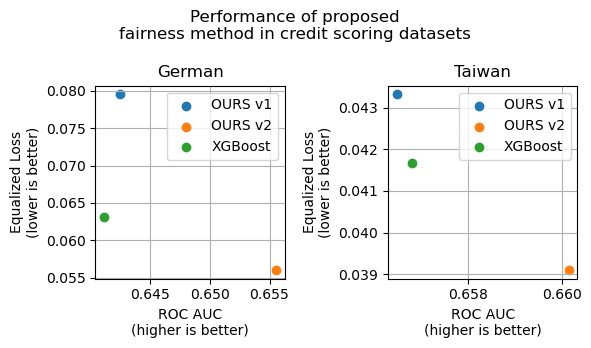

In [36]:
results_to_plot = results[results.set == "test"].groupby(["dataset", "set", "fairness"]).agg(lambda x : np.abs(x).mean()).reset_index()
results_to_plot = results_to_plot.iloc[:, ::-1]

fig, axs = plt.subplots(1, 2, figsize=(6, 3.5))
better_names = {
    "fair" : "OURS v1",
    "fair2" : "OURS v2",
    "no_fair" : "XGBoost"
}
dataset_names = {
    "german" : "German",
    "taiwan" : "Taiwan"
}

for i, dataset in enumerate(["german", "taiwan"]):
    for j, row in results_to_plot[results_to_plot.dataset == dataset].iterrows():
        axs[i].scatter(row["roc"], row["el"], label=better_names[row["fairness"]])

    axs[i].set_xlabel("ROC AUC\n(higher is better)")
    axs[i].set_ylabel("Equalized Loss\n(lower is better)")
    axs[i].set_title(dataset_names[dataset])
    axs[i].legend()
    axs[i].grid()


plt.suptitle("Performance of proposed\nfairness method in credit scoring datasets")
plt.tight_layout()
plt.show()

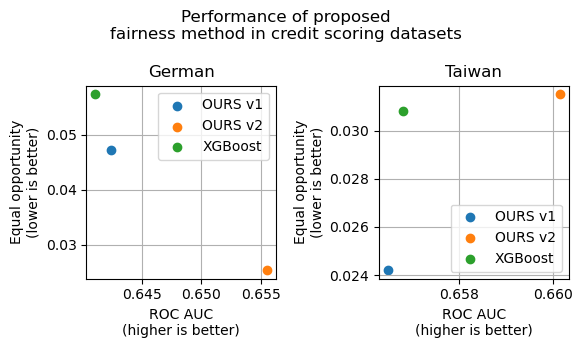

In [38]:
results_to_plot = results[results.set == "test"].groupby(["dataset", "set", "fairness"]).agg(lambda x : np.abs(x).mean()).reset_index()
results_to_plot = results_to_plot.iloc[:, ::-1]

fig, axs = plt.subplots(1, 2, figsize=(6, 3.5))
better_names = {
    "fair" : "OURS v1",
    "fair2" : "OURS v2",
    "no_fair" : "XGBoost"
}
dataset_names = {
    "german" : "German",
    "taiwan" : "Taiwan"
}

for i, dataset in enumerate(["german", "taiwan"]):
    for j, row in results_to_plot[results_to_plot.dataset == dataset].iterrows():
        axs[i].scatter(row["roc"], row["eop"], label=better_names[row["fairness"]])

    axs[i].set_xlabel("ROC AUC\n(higher is better)")
    axs[i].set_ylabel("Equal opportunity\n(lower is better)")
    axs[i].set_title(dataset_names[dataset])
    axs[i].legend()
    axs[i].grid()


plt.suptitle("Performance of proposed\nfairness method in credit scoring datasets")
plt.tight_layout()
plt.show()

In [11]:
results_to_plot

,dataset,set,fairness,eop,spd,el,roc
0,german,test,fair,0.047181,0.048287,0.079510,0.642468
1,german,test,fair2,0.025487,0.042554,0.056057,0.655553
2,german,test,no_fair,0.057300,0.060360,0.063081,0.641095
3,taiwan,test,fair,0.024219,0.031834,0.043320,0.656488
4,taiwan,test,fair2,0.031505,0.032228,0.039106,0.660148
5,taiwan,test,no_fair,0.030811,0.030630,0.041676,0.656806


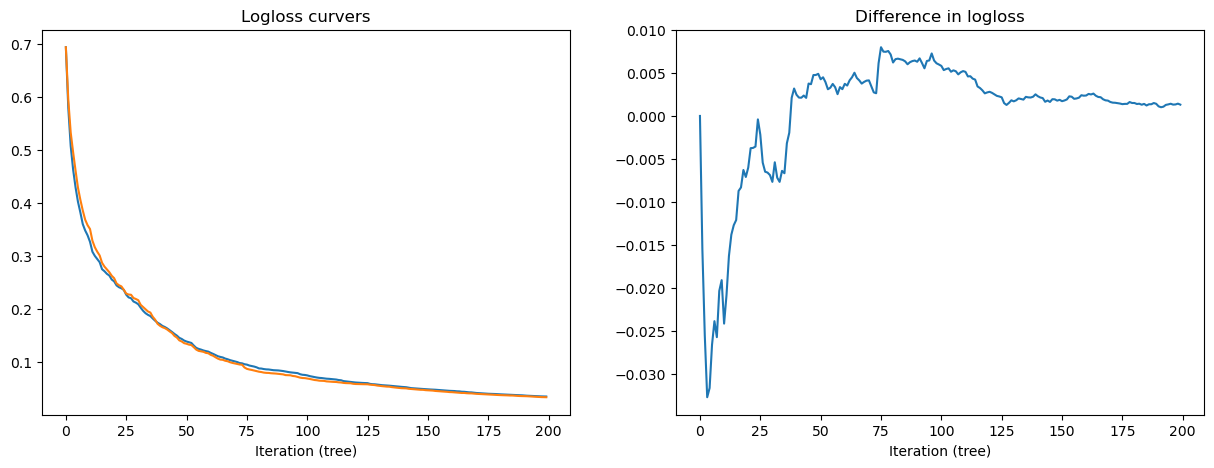

In [13]:
X, Y = data.load_dataset("german")
model = models.XtremeFair(alpha = 0.5, n_estimators = 200, fair_weight = 0.1, dual_learning="gradient")
model.fit(X, Y)
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(model.group_losses[:, 0]) 
plt.plot(model.group_losses[:, 1])
plt.title("Logloss curvers")
plt.xlabel("Iteration (tree)")
plt.subplot(1, 2, 2)
plt.plot(model.group_losses[:, 0] - model.group_losses[:, 1])
plt.title("Difference in logloss")
plt.xlabel("Iteration (tree)")
plt.show()

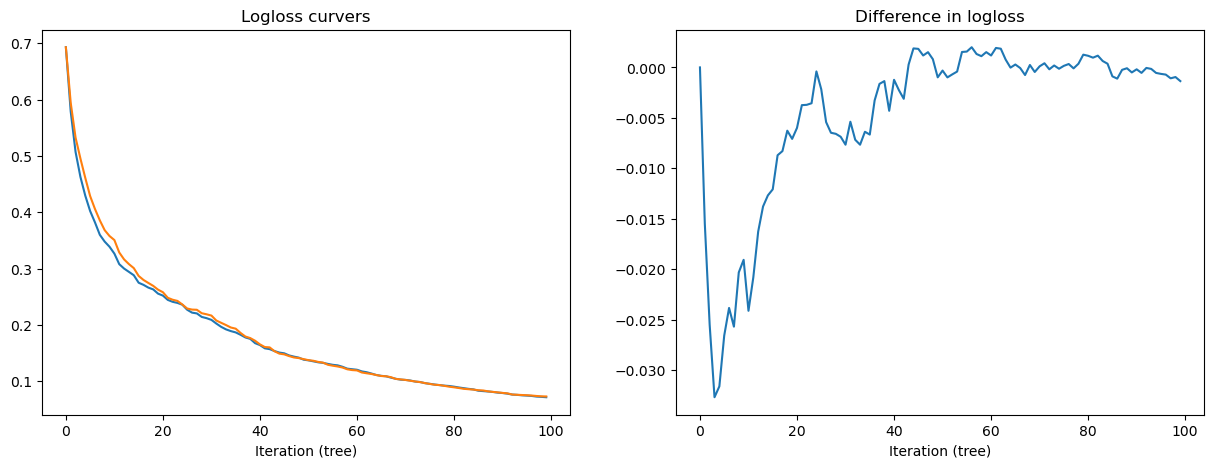

In [11]:
X, Y = data.load_dataset("german")
model = models.XtremeFair(alpha = 0.5, n_estimators = 100, fair_weight = 0.1, dual_learning="gradient")
model.fit(X, Y)
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(model.group_losses[:, 0]) 
plt.plot(model.group_losses[:, 1])
plt.title("Logloss curvers")
plt.xlabel("Iteration (tree)")
plt.subplot(1, 2, 2)
plt.plot(model.group_losses[:, 0] - model.group_losses[:, 1])
plt.title("Difference in logloss")
plt.xlabel("Iteration (tree)")
plt.show()

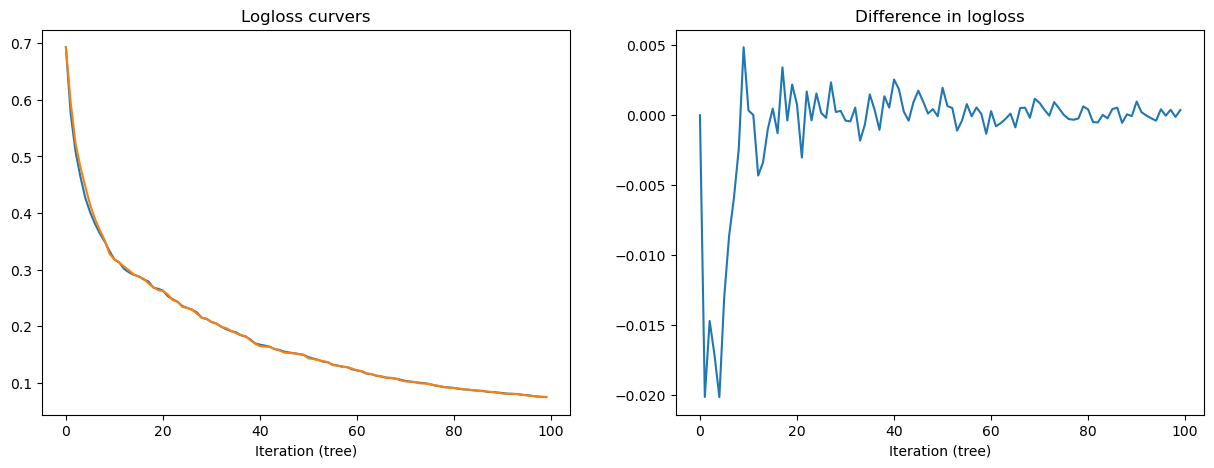

In [9]:
X, Y = data.load_dataset("german")
model = models.XtremeFair(alpha = 0.5, n_estimators = 100, fair_weight = 0.1, dual_learning="optim")
model.fit(X, Y)
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(model.group_losses[:, 0]) 
plt.plot(model.group_losses[:, 1])
plt.title("Logloss curvers")
plt.xlabel("Iteration (tree)")
plt.subplot(1, 2, 2)
plt.plot(model.group_losses[:, 0] - model.group_losses[:, 1])
plt.title("Difference in logloss")
plt.xlabel("Iteration (tree)")
plt.show()

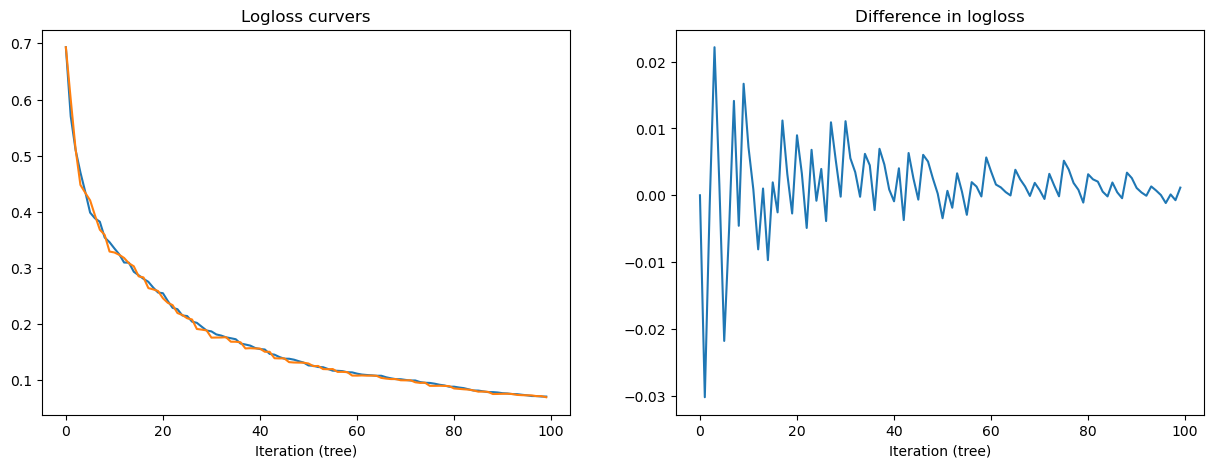

In [97]:
X, Y = data.load_dataset("german")
model = models.XtremeFair(alpha = 0.5, n_estimators = 100)
model.fit(X, Y)
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(model.group_losses[:, 0]) 
plt.plot(model.group_losses[:, 1])
plt.title("Logloss curvers")
plt.xlabel("Iteration (tree)")
plt.subplot(1, 2, 2)
plt.plot(model.group_losses[:, 0] - model.group_losses[:, 1])
plt.title("Difference in logloss")
plt.xlabel("Iteration (tree)")
plt.show()

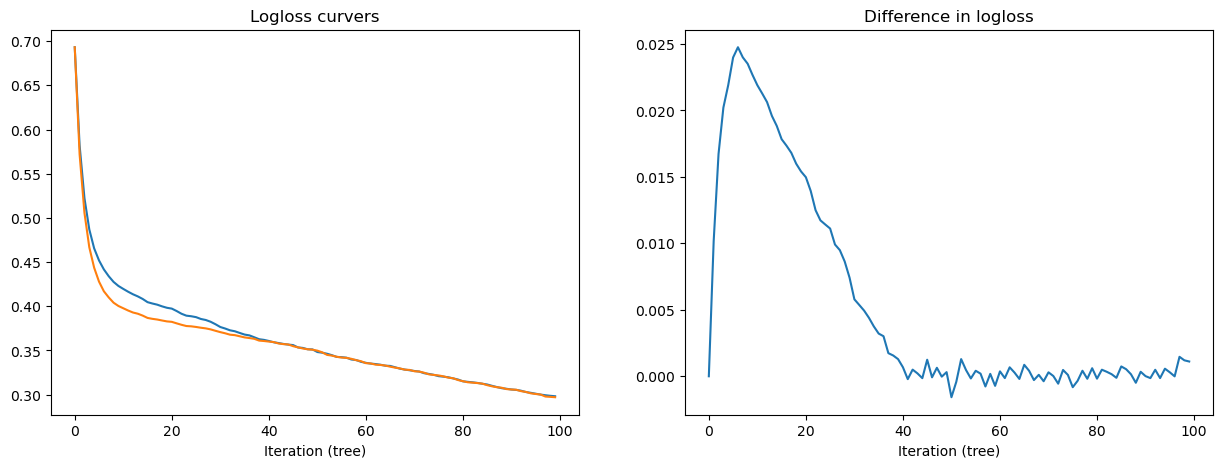

In [57]:
X, Y = data.load_dataset("taiwan")
model = models.XtremeFair(alpha = 0.5, n_estimators = 100, fair_weight = 0.3)
model.fit(X, Y)
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(model.group_losses[:, 0]) 
plt.plot(model.group_losses[:, 1])
plt.title("Logloss curvers")
plt.xlabel("Iteration (tree)")
plt.subplot(1, 2, 2)
plt.plot(model.group_losses[:, 0] - model.group_losses[:, 1])
plt.title("Difference in logloss")
plt.xlabel("Iteration (tree)")
plt.show()

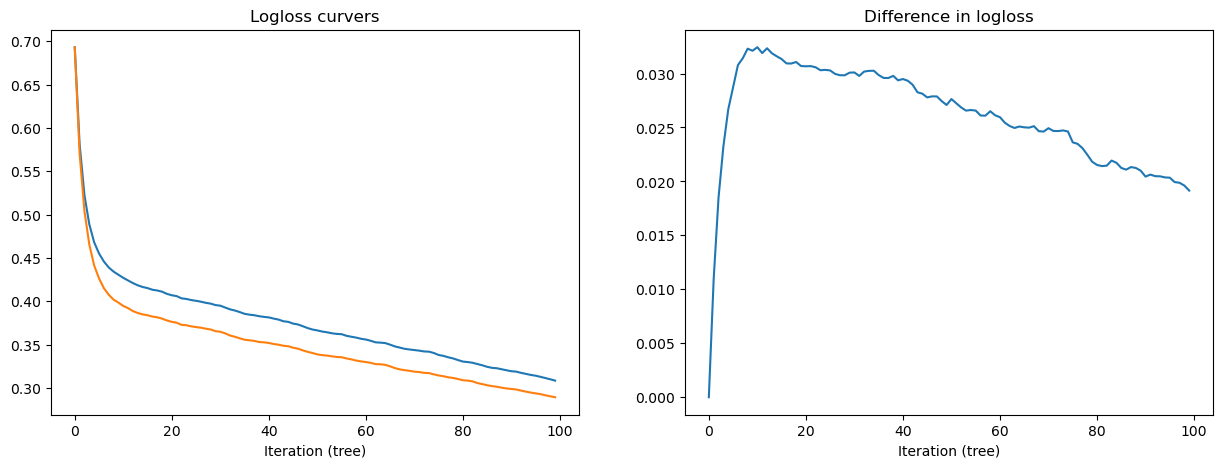

In [54]:
X, Y = data.load_dataset("taiwan")
model = models.XtremeFair(alpha = 0.5, n_estimators = 100, fair_weight = 0)
model.fit(X, Y)
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(model.group_losses[:, 0]) 
plt.plot(model.group_losses[:, 1])
plt.title("Logloss curvers")
plt.xlabel("Iteration (tree)")
plt.subplot(1, 2, 2)
plt.plot(model.group_losses[:, 0] - model.group_losses[:, 1])
plt.title("Difference in logloss")
plt.xlabel("Iteration (tree)")
plt.show()

In [50]:
def dual_obj_smooth(fair_weight, mu_opt_list, learning_rate, group_losses):
    def custom_obj(predt, dtrain):
        subgroup = (dtrain.get_data()[:, 0]).toarray().reshape(-1)
        n = len(subgroup)
        n_g = get_subgroup_indicator(subgroup)
        loss_group = logloss_group(predt, dtrain, subgroup)
        group_losses.append(loss_group)
        if fair_weight > 0:
            # dual problem solved analytically
            idx_biggest_loss = np.where(loss_group == np.max(loss_group))[0]
            # if is more than one, randomly choose one
            idx_biggest_loss = np.random.choice(idx_biggest_loss)
            new_mu_opt = np.zeros(loss_group.shape[0])
            new_mu_opt[idx_biggest_loss] = fair_weight
            mu_opt = mu_opt_list[-1] + learning_rate * (new_mu_opt - mu_opt_list[-1])
            #mu_opt = mu_opt_list[-1] + learning_rate * loss_group 
            mu_opt_list.append(mu_opt)

        else:
            mu_opt = np.zeros(len(np.unique(subgroup)))
            mu_opt = mu_opt_list[-1] + learning_rate * (new_mu_opt - mu_opt_list[-1])
            mu_opt_list.append(mu_opt)

        multiplier = n / (1 + fair_weight) * (1 / n + np.sum(n_g * mu_opt, axis=1))
        grad = logloss_grad(predt, dtrain) * multiplier
        hess = logloss_hessian(predt, dtrain) * multiplier
        return grad, hess

    return custom_obj

class SmoothModel(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        fairness_constraint="equalized_loss",
        fair_weight=1,
        mu_learning_rate=0.1,
        n_estimators=10,
        eta=0.3,
        colsample_bytree=1,
        max_depth=6,
        min_child_weight=1,
        max_leaves=0,
        l2_weight=1,
        alpha=1,
        performance_metric="accuracy",
        fairness_metric="EOP",
        seed=None,
    ):
        assert fairness_constraint in ["equalized_loss"]
        assert performance_metric in ["accuracy", "auc"]
        assert fairness_metric in ["EOP", "SPD"]

        self.fairness_constraint = fairness_constraint
        self.fair_weight = fair_weight
        self.mu_learning_rate = mu_learning_rate
        self.n_estimators = n_estimators
        self.eta = eta
        self.colsample_bytree = colsample_bytree
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.max_leaves = max_leaves
        self.l2_weight = l2_weight
        self.alpha = alpha
        self.performance_metric = performance_metric
        self.fairness_metric = fairness_metric
        self.seed = seed
        self.group_losses = []

    def fit(self, X, y):
        """Fit the model to the data.


        Parameters
        ----------
        X : pandas.DataFrame
            Dataframe of shape (n_samples, n_features), sensitive attribute must be in the first column
        y : pandas.Series
            Labels array-like of shape (n_samples), must be (0 or 1)

        Returns
        -------
        XtremeFair
            Fitted model
        """
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        self.groups_ = np.unique(X[:, 0])
        self.mu_opt = np.ones(len(self.groups_)) / len(self.groups_) * self.fair_weight
        self.mu_opt_list = [self.mu_opt]
        dtrain = xgb.DMatrix(X, label=y)

        params = {
            "tree_method": "hist",
            "objective": "binary:logistic",
            "eta": self.eta,
            "colsample_bytree": self.colsample_bytree,
            "max_depth": self.max_depth,
            "min_child_weight": self.min_child_weight,
            "max_leaves": self.max_leaves,
            "lambda": self.l2_weight,
        }
        if self.seed is not None:
            params["seed"] = self.seed

        self.model_ = xgb.train(
            params,
            dtrain,
            num_boost_round=self.n_estimators,
            obj=dual_obj_smooth(self.fair_weight, self.mu_opt_list, self.mu_learning_rate, self.group_losses),
        )
        self.group_losses = np.array(self.group_losses)
        return self

    def predict(self, X):
        """Predict the labels of the data."""
        check_is_fitted(self)
        X = check_array(X)
        dtest = xgb.DMatrix(X)
        preds = self.model_.predict(dtest)
        return (preds > 0.5).astype(int)

    def predict_proba(self, X):
        """Predict the probabilities of the data."""
        check_is_fitted(self)
        X = check_array(X)
        dtest = xgb.DMatrix(X)
        preds_pos = self.model_.predict(dtest)
        preds = np.ones((preds_pos.shape[0], 2))
        preds[:, 1] = preds_pos
        preds[:, 0] -= preds_pos
        return preds

0.31


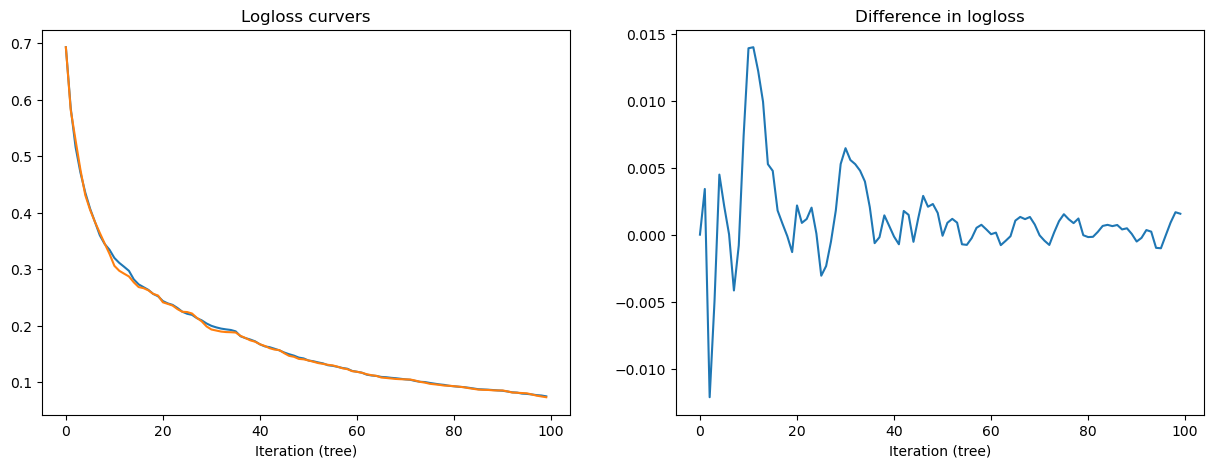

In [51]:
X, Y = data.load_dataset("german")
print(X.iloc[:, 0].mean())
model = SmoothModel(n_estimators = 100, mu_learning_rate=0.1)
model.fit(X, Y)
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(model.group_losses[:, 0]) 
plt.plot(model.group_losses[:, 1])
plt.title("Logloss curvers")
plt.xlabel("Iteration (tree)")
plt.subplot(1, 2, 2)
plt.plot(model.group_losses[:, 0] - model.group_losses[:, 1])
plt.title("Difference in logloss")
plt.xlabel("Iteration (tree)")
plt.show()

0.6037333333333333


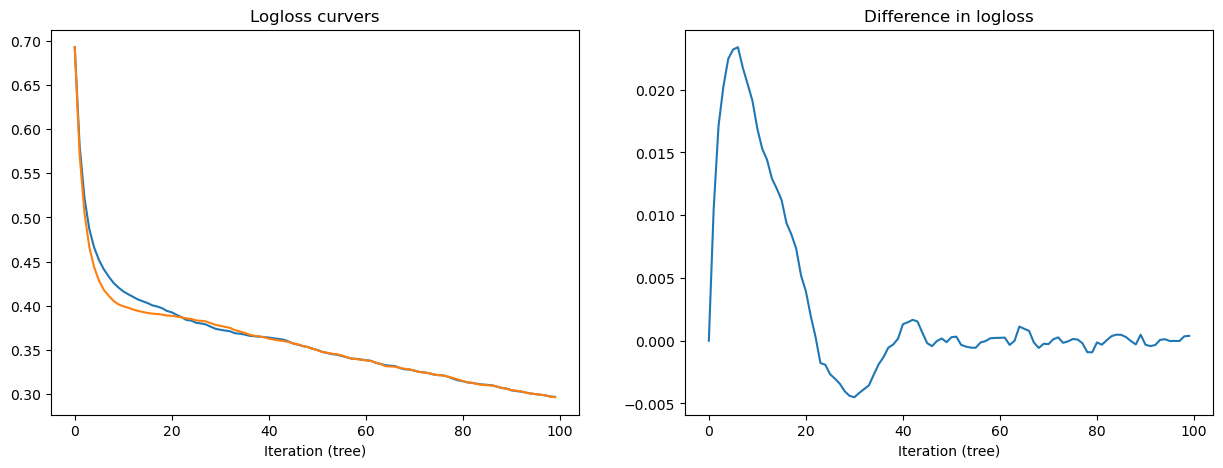

In [46]:
X, Y = data.load_dataset("taiwan")
print(X.iloc[:, 0].mean())
model = SmoothModel(n_estimators = 100, mu_learning_rate=0.1)
model.fit(X, Y)
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(model.group_losses[:, 0]) 
plt.plot(model.group_losses[:, 1])
plt.title("Logloss curvers")
plt.xlabel("Iteration (tree)")
plt.subplot(1, 2, 2)
plt.plot(model.group_losses[:, 0] - model.group_losses[:, 1])
plt.title("Difference in logloss")
plt.xlabel("Iteration (tree)")
plt.show()